In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# 1. Dataset
- MNIST

In [2]:
%%capture
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.MNIST(
    root='/tmp/mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.MNIST(
    root='/tmp/mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

#### DataLoader

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

In [4]:
print(len(train_loader))
for Xb_train, yb_train in train_loader:
    print(Xb_train.shape, yb_train.shape)
    Xb_train = Xb_train.view(-1, 28, 28)
    print(Xb_train.shape, yb_train.shape)
    break

469
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 28, 28]) torch.Size([128])


# 2. Model

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.input_size = n_inputs
        self.hidden_size = n_hidden
        self.output_dim = n_outputs
        self.num_layers = n_rnnlayers

        # LSTM layer
        self.rnn = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True)

        # Linear layer
        self.fc =nn.Linear(self.hidden_size, self.output_dim)

    def forward(self, X):
        # initial hidden states: X.size(0) = batchsize
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# Model
model = RNN(
    n_inputs=28,
    n_hidden=128,
    n_rnnlayers=2,
    n_outputs=10)
model.to(device)

# Loss
ce_loss = nn.CrossEntropyLoss()

# Optimizer
adam_opt = torch.optim.Adam(model.parameters())

# 3. Train

In [8]:
def fit(train_loader, valid_loader, model, loss_fn, optimizer, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for i in range(n_epochs):
        # Train by batches
        train_batch_loss = []
        for X_b, y_b in train_loader:
            # Load data to GPU
            X_train, y_train = X_b.to(device), y_b.to(device)

            # reshape the input
            X_train = X_train.view(-1, 28, 28)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            y_train_ = model(X_train)
            loss = loss_fn(y_train_, y_train)

            # Backward
            loss.backward()
            optimizer.step()

            train_batch_loss.append(loss.item())

        # Valid by batches
        valid_batch_loss = []
        for X_valid, y_valid in test_loader:
            # Load data to GPU
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            # reshape the input
            X_valid = X_valid.view(-1, 28, 28)

            # fit
            y_valid_ = model(X_valid)
            loss = loss_fn(y_valid_, y_valid)

            valid_batch_loss.append(loss.item())


        # Save losses
        train_loss = np.mean(train_batch_loss)
        valid_loss = np.mean(valid_batch_loss)
        train_losses[i] = train_loss
        valid_losses[i] = valid_loss
            
        if (i+1) % 2 == 0:
            print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Plot
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.show()

Epoch 2/20, Train Loss: 0.1276, Valid Loss: 0.1212
Epoch 4/20, Train Loss: 0.0618, Valid Loss: 0.0723
Epoch 6/20, Train Loss: 0.0422, Valid Loss: 0.0512
Epoch 8/20, Train Loss: 0.0315, Valid Loss: 0.0411
Epoch 10/20, Train Loss: 0.0254, Valid Loss: 0.0524
Epoch 12/20, Train Loss: 0.0198, Valid Loss: 0.0378
Epoch 14/20, Train Loss: 0.0169, Valid Loss: 0.0372
Epoch 16/20, Train Loss: 0.0145, Valid Loss: 0.0414
Epoch 18/20, Train Loss: 0.0117, Valid Loss: 0.0446
Epoch 20/20, Train Loss: 0.0137, Valid Loss: 0.0321


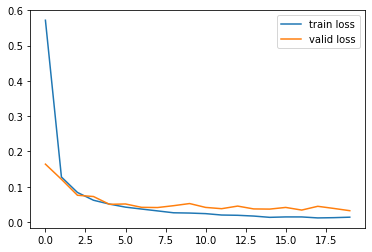

In [9]:
valid_loader = test_loader

fit(train_loader, valid_loader,
    model=model, loss_fn=ce_loss, optimizer=adam_opt,
    n_epochs=20)

# 4. Test
#### Accuracy

In [10]:
n_correct = 0.
n_total = 0.
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # reshape the input
    Xb_test = Xb_test.view(-1, 28, 28)

    # Fit
    yb_test_ = model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update counts
    n_correct += (predictions == yb_test).sum().item()
    n_total += yb_test.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.9907


#### Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1130    2    1    0    1    0    1    0    0]
 [   1    2 1022    1    1    0    0    5    0    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  966    0    3    1    0   12]
 [   0    0    1    2    0  887    0    0    2    0]
 [   2    2    0    0    2    6  945    0    1    0]
 [   0    4    2    0    0    1    0 1019    1    1]
 [   0    1    0    5    1    3    0    3  960    1]
 [   0    0    0    0    7    2    0    3    1  996]]


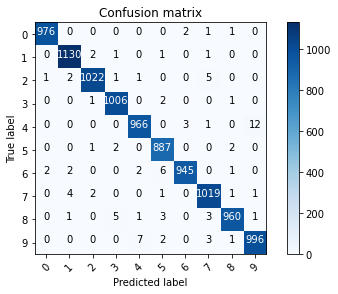

In [12]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # reshape the input
    Xb_test = Xb_test.view(-1, 28, 28)

    # Fit
    yb_test_ = model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

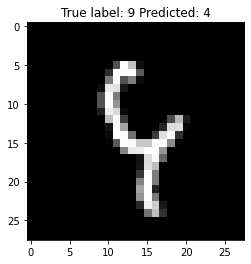

In [13]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));